# Projet Machine Learning - Pump it Up Data Mining the Water Table

Using data from Taarifa and the Tanzanian Ministry of Water, the goal is to predict which pumps are functional, which need some repairs, and which are not functionnal at all.
Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## I - Packages and input data

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

from codes.map_design import displayMap
from codes.predicteurs import Predict
from codes.data_processing import processData
from codes.unbalanced_predictions import unbalancedPrediction
from codes.getExtraData import regions_list, url_regions, url_all_regions, get_label_climat_region, get_informations

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/map_design.py:11: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


In [2]:
path = os.getcwd()

# Import des données
train_set = pd.read_csv(path + '/data/training_set_values.csv', sep=',')
test_set = pd.read_csv(path + '/data/test_set_values.csv', sep=',')
train_labels = pd.read_csv(path + '/data/training_set_labels.csv', sep=',')

## II - Display the pump repartition on the Tanzanian map

(Using the class displayMap)

In [ ]:
# Display the map
data = pd.merge(train_set, train_labels, how='inner')
map_water_pumps = displayMap(data, 'status_group')
map_water_pumps.display_map()
plt.show()

## III - Scrapp extra data

(from climate-data.org)

In [3]:
climat_infos_region = get_label_climat_region(regions_list, url_regions)
climat_infos_wpt = get_informations(url_all_regions)

In [4]:
climat_infos_region.head()

,region,label_climat_reg
0,arusha,Csb
1,dar es salaam,Aw
2,dodoma,BSh
3,geita,Aw
4,iringa,Csb


In [5]:
# Merge the data
# train set
train_set['region'] = train_set['region'].apply(lambda x: x.lower())
# infos regions
train_set = train_set.merge(climat_infos_region, on='region', how='left')
# infos wpt
train_set = train_set.merge(climat_infos_wpt, left_on='wpt_name', right_on='name', how='left')

# test set
test_set['region'] = test_set['region'].apply(lambda x: x.lower())
test_set = test_set.merge(climat_infos_region, on='region', how='left')
test_set = test_set.merge(climat_infos_wpt, left_on='wpt_name', right_on='name', how='left')

In [6]:
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source_type,source_class,waterpoint_type,waterpoint_type_group,label_climat_reg,name,infos,label_climat_wpt,temperature,pluviometrie
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,spring,groundwater,communal standpipe,communal standpipe,Csb,NaN,NaN,NaN,NaN,NaN
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw,NaN,NaN,NaN,NaN,NaN
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,dam,surface,communal standpipe multiple,communal standpipe,Csb,NaN,NaN,NaN,NaN,NaN
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,borehole,groundwater,communal standpipe multiple,communal standpipe,Aw,NaN,NaN,NaN,NaN,NaN
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw,NaN,NaN,NaN,NaN,NaN


In [7]:
train_set.shape

(59400, 46)

## IV - Exploratory Data Analysis 

In [8]:
train_set['density_population'] = train_set['population']/np.sum(train_set['population'])
test_set['density_population'] = test_set['population']/np.sum(test_set['population'])

# Which variable are categorical and which one are numerical
test_variable_float = np.float64(2)
test_variable_int = np.int64(1)

categorical = list()
numerical = list()

for x in train_set.columns:
    if (type(train_set[x].iloc[1]) == type(test_variable_float) or
       type(train_set[x].iloc[1]) == type(test_variable_int)):
        numerical.append(x)
    else:
        categorical.append(x)

print('Categorical variables:')
print(categorical)
print()
print('Numerical variables:')
print(numerical)

Categorical variables:
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'label_climat_reg', 'name', 'infos', 'label_climat_wpt']

Numerical variables:
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'temperature', 'pluviometrie', 'density_population']


In [9]:
# How many categorical ?
print('Number of categorical variables:', len(categorical))
# How many numerical ?
print('Number of numerical variables:', len(numerical))

Number of categorical variables: 34
Number of numerical variables: 13


In [10]:
# Missing value by feature ? 
missing = train_set.apply(lambda x: x.isnull().sum(), axis = 0)
missing = pd.DataFrame(missing)
missing. columns = ["Number of missing values"]

# Share of missing 
missing['Share of missing'] = round(missing['Number of missing values']/len(train_set)*100,2)

# Number of categories ?
number_c = list()
for x in train_set.columns:
    if x in categorical:
        number_c.append(len(train_set[x].unique()))
    else:
        number_c.append('numerical')

# DataFrame
missing['Number of categories'] = number_c
print(missing)

                       Number of missing values  Share of missing  \
id                                            0              0.00   
amount_tsh                                    0              0.00   
date_recorded                                 0              0.00   
funder                                     3635              6.12   
gps_height                                    0              0.00   
installer                                  3655              6.15   
longitude                                     0              0.00   
latitude                                      0              0.00   
wpt_name                                      0              0.00   
num_private                                   0              0.00   
basin                                         0              0.00   
subvillage                                  371              0.62   
region                                        0              0.00   
region_code                       

In [11]:
# Take a look only on features with missing data 
interest = missing[missing['Number of missing values'] != 0]
print(interest)

                   Number of missing values  Share of missing  \
funder                                 3635              6.12   
installer                              3655              6.15   
subvillage                              371              0.62   
public_meeting                         3334              5.61   
scheme_management                      3877              6.53   
scheme_name                           28166             47.42   
permit                                 3056              5.14   
name                                  58535             98.54   
infos                                 58535             98.54   
label_climat_wpt                      58535             98.54   
temperature                           58535             98.54   
pluviometrie                          58535             98.54   

                  Number of categories  
funder                            1898  
installer                         2146  
subvillage                     

Among features with missing data except for 'public_meeting' and 'permit', either the share of missing value is too high or there is too many categories. Hence, we decide to consider these variables as non-informative. Therefore we will drop them in what follows.

The next step consists in checking the distribution of the class and deriving if some features are more discriminative than others. If yes, a feature importance analysis will be considered.

Functionnal:  54.31
Non-Functionnal:  38.42
Functional needs repair:  7.27


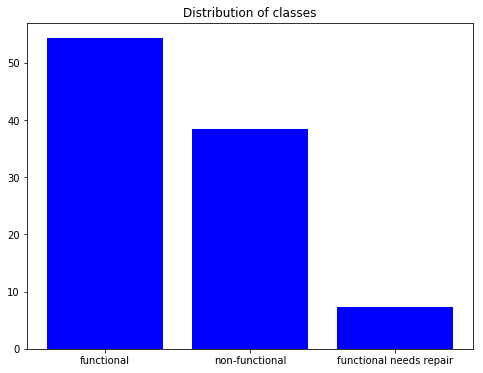

In [12]:
# Distribution of classes
legend = ['functional', 'non-functional', 'functional needs repair']
x = np.arange(len(train_labels['status_group'].unique()))
distrib = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
           for x in train_labels['status_group'].unique()]

# List of distribution 
print('Functionnal: ', distrib[0])
print('Non-Functionnal: ', distrib[1])
print('Functional needs repair: ', distrib[2])

# Plot dsitribution as barplot
plt.figure(figsize=(8, 6))
plt.bar(x, distrib, color = 'blue')
plt.xticks(x, legend)
plt.title('Distribution of classes')
plt.show()

This first plot shows we face an heterogenous problem. Especially the class "functional needs repair" is under represented. It is straightforward to point out that in merging "non-functional" and "functional needs repair" we obtain an almost-homegenous problem of supervised classification.

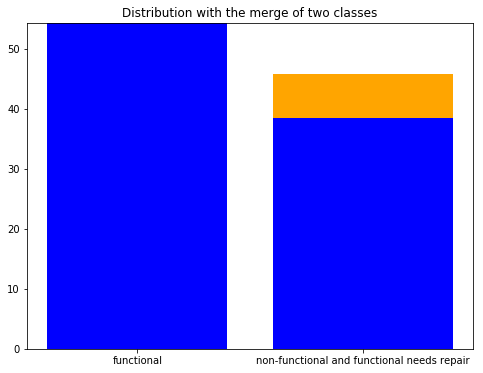

In [13]:
# Merge both under-represented classes
N = np.arange(2)
legend = ['functional', 'non-functional and functional needs repair']

distrib_1 = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
             for x in ['functional', 'non functional']]
distrib_2 = [0, round(train_labels[train_labels['status_group'] == 'functional needs repair']['status_group'].count()/len(train_labels)*100,2)]

# Plot new distrib
plt.figure(figsize=(8, 6))
plt.bar(N, distrib_1, color = 'blue')
plt.bar(N, distrib_2, color = 'orange', bottom = distrib_1)
plt.xticks(N, legend)
plt.title('Distribution with the merge of two classes')
plt.show()

In [14]:
# Feature importance
X = train_set.copy()

# List of category to remove
to_remove = ['funder', 'installer', 'subvillage', 'scheme_management', 'scheme_name']

# Remove the data previously identified
X = X.drop(to_remove, axis=1)

# Also in the categorical list
for item in to_remove:
    if item in categorical:
        categorical.remove(item)

y = train_labels.copy()
data = pd.merge(X, y)

# Encode the dataset
data_transformer = processData(data)

transformed = data_transformer.get_processData(categorical,
                                               numerical)
X, y, code = transformed

In [15]:
print('Shape of X:', X.shape)

Shape of X: (59400, 42)


In [16]:
# Handle missing values - Use the mean strategy
feature_names = list(X.columns)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)       
X_temp = imp.transform(X)
X = pd.DataFrame(X_temp)
X.columns = feature_names

In [17]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(np.array(X), np.array(y))
print('Feature importance coefficient:')
print(clf.feature_importances_)

Feature importance coefficient:
[0.05789087 0.01092571 0.04880032 0.04258131 0.07611505 0.07575995
 0.05640523 0.00145865 0.0150795  0.0153032  0.0136962  0.01884388
 0.02009485 0.038701   0.02558871 0.01075314 0.         0.01355354
 0.03529279 0.01541142 0.0181473  0.02594099 0.01622209 0.01155557
 0.0267469  0.01919927 0.00935108 0.01191609 0.06635781 0.06117395
 0.01236063 0.01294753 0.00667182 0.03629244 0.02972166 0.01129747
 0.0012193  0.00114145 0.00115894 0.00121643 0.00121898 0.02588698]


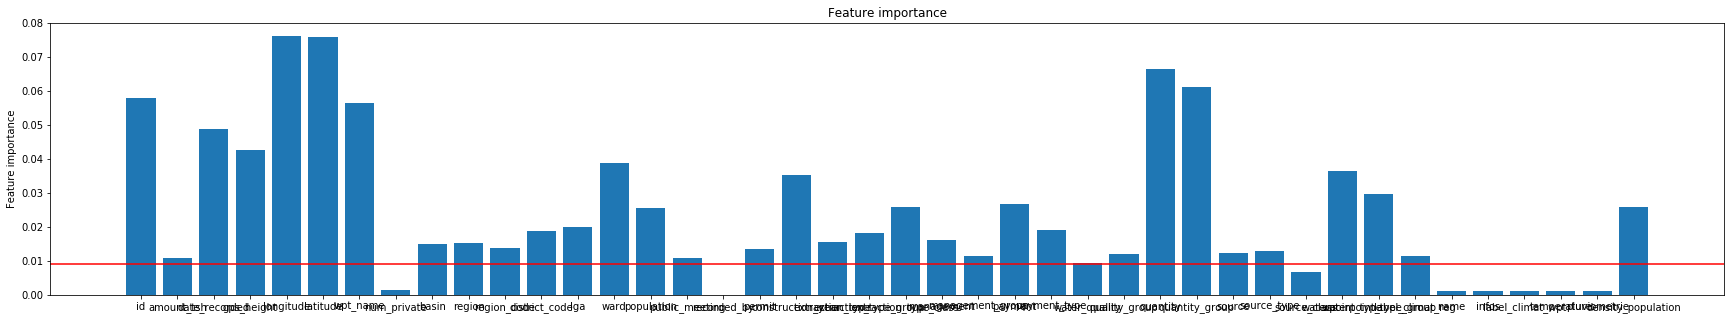

In [18]:
# Limitation for the feature importance
lim_feature_imp = 0.009
labels = X.columns
# Figure
fig = plt.figure(figsize=(30, 5))
plt.bar(np.arange(0, len(clf.feature_importances_)), clf.feature_importances_ )
plt.axhline(y=lim_feature_imp, color='r', linestyle='-')
plt.xticks(np.arange(0, len(clf.feature_importances_)), labels)
plt.ylabel('Feature importance')
plt.title('Feature importance')
plt.show()

In [19]:
# Selection of the variable:
variables_selected = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > lim_feature_imp:
        variables_selected.append(labels[i])

print('Variables selected with the feature importance analysis:')
print(variables_selected)

Variables selected with the feature importance analysis:
['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'wpt_name', 'basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group', 'label_climat_reg', 'density_population']


## V - 1 - Predictions & Submissions - 3 classes problem

In [20]:
# Select the id to submit
submit = pd.read_csv(path + '/data/SubmissionFormat.csv', sep=',')
submit_id = submit['id']
X = pd.concat([train_set, test_set], sort=False)

# Define the dataset to submit
X_submit = X.loc[X['id'].isin(submit_id)]
X_learn = X.loc[~X['id'].isin(submit_id)]
X_learn = pd.merge(X_learn, train_labels, on='id', how='inner')

# Variable selection
X_learn = X_learn[variables_selected]
X_submit = X_submit[variables_selected]


In [23]:
X_learn.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,label_climat_reg,density_population
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,none,Lake Nyasa,iringa,11,...,soft,good,enough,enough,spring,spring,communal standpipe,communal standpipe,Csb,0.000010
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,Zahanati,Lake Victoria,mara,20,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,communal standpipe,communal standpipe,Aw,0.000026
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,Kwa Mahundi,Pangani,manyara,21,...,soft,good,enough,enough,dam,dam,communal standpipe multiple,communal standpipe,Csb,0.000023
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,mtwara,90,...,soft,good,dry,dry,machine dbh,borehole,communal standpipe multiple,communal standpipe,Aw,0.000005
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,Shuleni,Lake Victoria,kagera,18,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,communal standpipe,communal standpipe,Aw,0.000000


In [24]:
X_learn.shape

(59400, 34)

In [25]:
# Categorical and numerical
# Which variable are categorical and which one are numerical
test_variable_float = np.float64(2)
test_variable_int = np.int64(1)
categorical_selected = list()
numerical_selected = list()

for x in variables_selected:
    if (type(X_learn[x].iloc[1]) == type(test_variable_float) or
       type(X_learn[x].iloc[1]) == type(test_variable_int)):
        numerical_selected.append(x)
    else:
        categorical_selected.append(x)

# Encode the dataset
data_transformer = processData(X_submit)
transformed = data_transformer.get_processData(categorical_selected,
                                               numerical_selected)
try:
    submit, y, code = transformed
except ValueError:
    submit = transformed


data_transformer = processData(X_learn)

transformed = data_transformer.get_processData(categorical_selected,
                                               numerical_selected)
try:
    X, y, code = transformed
except ValueError:
    X = transformed

# Handle missing values - Use the mean strategy
# X
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)       
X = imp.transform(X)
X = pd.DataFrame(X)
X.columns = variables_selected

# Submit
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(submit)       
submit = imp.transform(submit)
submit = pd.DataFrame(submit)
submit.columns = variables_selected

In [26]:
submit.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,label_climat_reg,density_population
0,50785.0,0.0,255.0,1996.0,35.290799,-4.059696,656.0,0.0,8.0,21.0,...,6.0,2.0,3.0,3.0,5.0,3.0,6.0,5.0,2.0,0.000117
1,51630.0,0.0,255.0,1569.0,36.656709,-3.309214,1780.0,5.0,0.0,2.0,...,6.0,2.0,2.0,2.0,8.0,6.0,1.0,1.0,2.0,0.000110
2,17168.0,0.0,252.0,1567.0,34.767863,-5.004344,9673.0,0.0,18.0,13.0,...,6.0,2.0,2.0,2.0,5.0,3.0,6.0,5.0,1.0,0.000183
3,45559.0,0.0,242.0,267.0,38.058046,-9.418672,5595.0,7.0,7.0,80.0,...,6.0,2.0,0.0,0.0,7.0,5.0,6.0,5.0,0.0,0.000091
4,49871.0,500.0,306.0,1260.0,35.006123,-10.950412,5706.0,7.0,16.0,10.0,...,6.0,2.0,1.0,1.0,8.0,6.0,1.0,1.0,0.0,0.000022


In [27]:
X.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,basin,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,label_climat_reg,density_population
0,69572.0,6000.0,47.0,1390.0,34.938093,-9.856322,37399.0,1.0,3.0,11.0,...,6.0,2.0,1.0,1.0,8.0,6.0,1.0,1.0,2.0,0.000010
1,8776.0,0.0,309.0,1399.0,34.698766,-2.147466,37195.0,4.0,9.0,20.0,...,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,0.0,0.000026
2,34310.0,25.0,300.0,686.0,37.460664,-3.821329,14572.0,5.0,8.0,21.0,...,6.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,0.000023
3,67743.0,0.0,272.0,263.0,38.486161,-11.155298,37285.0,7.0,12.0,90.0,...,6.0,2.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.000005
4,19728.0,0.0,104.0,0.0,31.130847,-1.825359,35529.0,4.0,4.0,18.0,...,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,0.0,0.000000


In [28]:
print('X shape:', X.shape)
print('Submit shape:', submit.shape)

X shape: (59400, 34)
Submit shape: (14850, 34)


### Predictions

In [ ]:
# Predict
#sm = SMOTE(random_state=2)
#X_sm, y_sm = sm.fit_sample(X, y.ravel())
predicteur = Predict(X, y)

# time
start = time.time()

ArbreDecision_predictions = predicteur.make_prediction('ArbreDecision', submit)
XGBoost_predictions = predicteur.make_prediction('XgBoost', submit)
RandomForest_predictions = predicteur.make_prediction('RandomForest', submit)
GradientBoosting_predictions = predicteur.make_prediction('GradientBoosting', submit)

exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Scores
print('Score Arbre de décision: ', ArbreDecision_predictions[1])
print('Score XGBoost: ', XGBoost_predictions[1])
print('Score GradientBoosting: ', GradientBoosting_predictions[1])
print('Score RandomForest: ', RandomForest_predictions[1])

In [ ]:
# Distribution of the predictions of the best predictor
pred = XGBoost_predictions[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [ ]:
# Prediction of the dataset - Submit
path_submit = path + '/submissions'

# Best model
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_predictions[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost.csv', sep=",",
                 header=True, index=False)

## V - 2 - Predictions & Submissions - 2/2 classes problem

### Predictions

In [ ]:
# Predict with the SMOTE method
# time
start = time.time()

# ArbreDecision
ArbreDecision = unbalancedPrediction(X, y, submit, 'ArbreDecision', variables_selected)
ArbreDecision_pred = ArbreDecision.processDataPredicted()

# XGBoost
XGBoost = unbalancedPrediction(X, y, submit, 'XgBoost', variables_selected)
XGBoost_pred = XGBoost.processDataPredicted()

# RandomForest
RandomForest = unbalancedPrediction(X, y, submit, 'RandomForest', variables_selected)
RandomForest_pred = RandomForest.processDataPredicted()

# GradientBoosting
GradientBoosting = unbalancedPrediction(X, y, submit, 'GradientBoosting', variables_selected)
GradientBoosting_pred = GradientBoosting.processDataPredicted()

exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Score
print('Score Arbre de décision: ', ArbreDecision_pred[1])
print('Score XGBoost: ', XGBoost_pred[1])
print('Score GradientBoosting: ', GradientBoosting_pred[1])
print('Score RandomForest: ', RandomForest_pred[1])

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['Class 2'] = y2_score


In [ ]:
# Distribution of the predictions of the best predictor
pred = XGBoost_pred[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [ ]:
# XGBoost
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_pred[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost_smote.csv', sep=",",
                 header=True, index=False)